# Predicting Bike Rentals
Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities that collects detailed data on the number of bicycles people rent by the hour and day.

Each row in the data we'll be using represents the number of bike rentals for a single hour of a single day. You can download the data from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In this project, we'll predict the total number of bikes people rented in a given hour. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

### Summary of Results
Our Random Forest model was the best model we created with an R2 score of 0.942.

## Introduction to the Dataset

In [1]:
# Read in the data
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Below is the data dictionary taken from the UCI Machine Learning Repository.

Variable | Definition | Key
----------|-----------|----
instant|record index|
dteday|date|
season|season|1:winter, 2:spring, 3:summer, 4:fall 
yr|year|0: 2011, 1:2012
mnth|month|1 to 12 
hr|hour|0 to 23
holiday|whether day is holiday or not (extracted from [Web Link])|0 or 1
weekday|day of the week 
workingday|if day is neither weekend nor holiday is 1, otherwise is 0. 
weathersit| 1: Clear, Few clouds, Partly cloudy, Partly cloudy, 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp|Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) 
atemp|Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) 
hum|Normalized humidity. The values are divided to 100 (max) 
windspeed|Normalized wind speed. The values are divided to 67 (max) 
casual|count of casual users 
registered|count of registered users 
cnt|count of total rental bikes including both casual and registered 

Text(0, 0.5, 'Frequency')

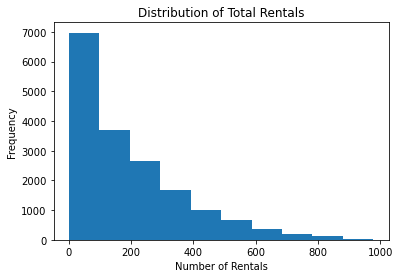

In [2]:
# Histogram plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals['cnt'])
plt.title("Distribution of Total Rentals")
plt.xlabel("Number of Rentals")
plt.ylabel("Frequency")

In [3]:
# Correlation of the count of bicycles rented to other columns
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

## Calculating Features

It can often be helpful to calculate features before applying ML models, since features can enhance the the accuracy of models by introducing new information or distilling existing information.

In [4]:
bike_rentals['hr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

The `hr` column in `bike_rentals` contains the hours during which bikes are rented. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This bundles similar times together, enabling the model to make better decisions.

In [5]:
def assign_label(hour):
    if 0 <= hour < 6:
        return 4
    elif 6 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    elif 18 <= hour < 24:
        return 3

In [6]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Splitting the Data into Train and Test Sets

In [7]:
# 80/20 split
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

In [8]:
# trim the columns for training
predictor_cols = list(train.columns)
predictor_cols.remove("cnt")         #target column
predictor_cols.remove("casual")      #leak data since their
predictor_cols.remove("registered")  #sum is the target column 
predictor_cols.remove("dteday")

predictor_cols

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(train[predictor_cols], train['cnt'])
predictions = lr.predict(test[predictor_cols])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['cnt'], predictions)

print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

mse: 17052.124871247568
rmse: 130.5837848710458
r2: 0.46220363568234224


The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. We saw this in the right-skewed histogram earlier. Larger errors are penalized more with MSE/RMSE, which leads to a higher total error.

## Applying Decision Trees

In [10]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(min_samples_leaf = 2, random_state=1)
dt.fit(train[predictor_cols], train['cnt'])
predictions = dt.predict(test[predictor_cols])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['cnt'], predictions)

print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

mse: 2962.7611238971995
rmse: 54.43125135340175
r2: 0.9065593189819846


In [11]:
dt = DecisionTreeRegressor(min_samples_leaf = 5, random_state=1)
dt.fit(train[predictor_cols], train['cnt'])
predictions = dt.predict(test[predictor_cols])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['cnt'], predictions)

print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

mse: 2742.890284482682
rmse: 52.37261005986509
r2: 0.9134936886836738


Compared to the linear regression model, the decision tree model seems to have a much higher accuracy as seen in the error metrics. We can also see that experimenting with parameters like `min_samples_leaf` makes a difference in the error.

## Applying Random Forests

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=1)
rf.fit(train[predictor_cols], train['cnt'])
predictions = rf.predict(test[predictor_cols])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['cnt'], predictions)

print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

mse: 1851.161871346375
rmse: 43.02513069528523
r2: 0.9416173566819115


In [13]:
rf = RandomForestRegressor(n_estimators=150, min_samples_leaf=5, random_state=1)
rf.fit(train[predictor_cols], train['cnt'])
predictions = rf.predict(test[predictor_cols])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['cnt'], predictions)

print("mse:", mse)
print("rmse:", rmse)
print("r2:", r2)

mse: 2050.4971013464215
rmse: 45.28241492396824
r2: 0.9353306467977254


The random forest accuracy is improved over the decision tree accuracy by removing some of the sources of overfitting. 

## Conclusion

Our Random Forest model, with its 0.942 score, seemed to be the best model for predicting bike rentals, slightly improving our Decision Tree model by tackling overfitting. Our Linear Regression, on the other hand, scored the worst due to outliers (high rental counts on some hours of some days).